In [3]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import os
import re
import imageio

import plotly.express as px

from uncertainties import ufloat as uf

# define a class to deal with the results

## 1 element incoming and 1 element in foil

In [4]:
# Define the fixed column width specs
global colspecs_ardn, colspecs_profile
colspecs_ardn = [(0, 14), (15, 34), (35, 50)]
colspecs_profile = [(0, 13), (13, 26), (26, 35), (37, 43)]

In [5]:
class TRIDYN_simulation:
    def __init__(self, file_retained = "", file_profiles = ""):
        self.file_retained = file_retained
        self.file_profiles = file_profiles
        self.fluence_vals = 0
        self.retained_vals = 0
        self.retained_calc = 0
        self.depth_vals = 0
        self.concentration_vals_implanted = 0
        self.concentration_vals_substrate = 0
        self.surface_density = 0
        
        
    def print_filenames(self):
        if (self.file_retained != ""):
            print("retained amount is located at " + self.file_retained + "\n")
        if (self.file_profiles != ""):
            print("Depth profiles is located at " + self.file_profiles + "\n")
            
            
    def load_retained(self):
        if (self.file_retained != ""):
            simulation = np.array(pd.read_fwf(self.file_retained, colspecs=colspecs_ardn, header=1).T)
            self.fluence_vals = simulation[0]
            self.retained_vals = simulation[2]
        else:
            print("No ardn file selected")
            self.fluence_vals = np.zeros(100)
            self.retained_vals = np.zeros(100)
      
    
    def load_profiles(self):
        if (self.file_profiles != ""):
            ls_files = os.listdir(path=self.file_profiles)
            
            self.depth_vals = []
            self.surface_density = []
            self.concentration_vals_substrate = []
            self.concentration_vals_implanted = []
            
            
            for i in range(len(ls_files)):
                directory_file = self.file_profiles + ls_files[i]
                
                single_profile = np.array(pd.read_fwf(directory_file, colspecs = colspecs_profile, header=4).T)
                
                for i in range(len(single_profile[2])):
                    single_profile[2][i] = np.float64(str(single_profile[2][i]).rstrip("-").lstrip("-"))
                    single_profile[3][i] = np.float64(str(single_profile[3][i]).rstrip("-").lstrip("-"))
                
                #print(single_profile[2])
                
                self.depth_vals.append(single_profile[0])
                self.surface_density.append(single_profile[1])
                self.concentration_vals_substrate.append(single_profile[2])
                self.concentration_vals_implanted.append(single_profile[3])
        
        else:
            print("No depth profile files selected")
            self.depth_vals = np.zeros((100, 100))
            self.surface_density = np.zeros((100, 100))
            self.concentration_vals_substrate = np.zeros((100, 100))
            self.concentration_vals_implanted = np.zeros((100, 100))
        
        
    def calc_retained(self, start_depth=0, end_depth=10**6):
        del_depth = self.depth_vals[0][1] - self.depth_vals[0][0]
        max_depth = self.depth_vals[0][-1] + del_depth/2
        self.retained_calc = np.zeros(len(self.retained_vals))
        
        for i in range(len(self.depth_vals)):            
            acc = 0
            
            for j in range(len(self.depth_vals[0])):    
                if ((self.depth_vals[0][j] > start_depth) and (self.depth_vals[0][j] < end_depth)):
                    acc += del_depth * self.concentration_vals_implanted[i][j] * self.surface_density[i][j]
            
            self.retained_calc[i] = acc        
        
        
    def load(self):
        self.load_retained()
        self.load_profiles()
        
        
    def draw_retained(self, **kwargs):
        plt.plot(self.fluence_vals, self.retained_vals)
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_lost(self, **kwargs):
        plt.plot(self.fluence_vals, self.fluence_vals - self.retained_vals)
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Lost fluence ($\AA ^{-2}$)")
        plt.grid()
        
    
    def draw_calc_retained(self, **kwargs):
        plt.plot(self.fluence_vals, self.retained_calc, "--")
        plt.xlabel("Implantation fluence ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_profile(self, index, bool_implant, **kwargs):
        if bool_implant:
            plt.plot(self.depth_vals[index], self.concentration_vals_implanted[index])

        else:
            plt.plot(self.depth_vals[index], self.concentration_vals_substrate[index])
        
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Concentration (%)")
        plt.grid()
        
        
    def draw_3d(self, **kwargs):
        X = self.depth_vals[0]
        Y = self.fluence_vals
        Z = self.concentration_vals_implanted
        
        X, Y = np.meshgrid(X, Y)
        
        im = pyl.pcolormesh(X, Y, Z, shading='auto')
        cbar = plt.colorbar(im,orientation='vertical')
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Fluence ($\AA ^{-2}$)")
        cbar.set_label("Atomic concentration (%)")

## Multiple incoming elements or multiple elements in the foil

In [6]:
class TRIDYN_simulation_mult:
    def __init__(self, file_retained = "", file_profiles = "",num_extend = 1,fractions = [1],elementen = ['X']):
        # fractions for a pure beam: [0,0,1] where there are (number of molecules in the foil)-1 zeros before the one
        # fractions for a non-pure beam: [a,b], where a is the fraction of the beam that corresponds to the first element in the beam and b to the second element
        self.file_retained = file_retained
        self.file_profiles = file_profiles
        self.fluence_vals = 0
        self.retained_vals = 0
        self.retained_calc = 0
        self.depth_vals = 0
        self.concentration_vals_implanted = 0
        self.concentration_vals_substrate = 0
        self.surface_density = 0
        self.num_extend = num_extend
        self.fractions = fractions
        self.elementen = elementen        
        
    def print_filenames(self):
        if (self.file_retained != ""):
            print("retained amount is located at " + self.file_retained + "\n")
        if (self.file_profiles != ""):
            print("Depth profiles is located at " + self.file_profiles + "\n")
            
            
    def load_retained(self):
        # determine the column width specs
        if (self.file_retained != ""):
            with open(self.file_retained) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else:
                    if inwoord == True:
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1      

            simulation = np.array(pd.read_fwf(self.file_retained, colspecs=colspecs, header=1).T) #areal density
            self.fluence_vals = simulation[0]
            self.retained_vals = []
            for ii in range(self.num_extend):
                self.retained_vals.append(simulation[2+ii])
        else:
            print("No ardn file selected")
            self.fluence_vals = np.zeros(100)
            self.retained_vals = np.zeros(100)
      
    
    def load_profiles(self):
        # determine the column width specs
        if (self.file_profiles != ""):        
            ls_files = os.listdir(path=self.file_profiles)
            path=self.file_profiles
            dirfile = path + ls_files[0]
            with open(dirfile) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else:
                    if inwoord == True: 
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1
                        
            self.depth_vals = []
            self.surface_density = []
            self.concentration_vals_substrate = []
            self.concentration_vals_implanted = []
            
            
            for i in range(len(ls_files)):
                directory_file = self.file_profiles + ls_files[i]
                
                single_profile = np.array(pd.read_fwf(directory_file, colspecs = colspecs, header=4).T)
                
                for i in range(len(single_profile[2])):
                    for jj in range(self.num_extend+1):
                        single_profile[jj+2][i] = np.float64(str(single_profile[jj+2][i]).rstrip("-").lstrip("-"))
                
                self.depth_vals.append(single_profile[0])
                self.surface_density.append(single_profile[1])
                self.concentration_vals_substrate.append(single_profile[2])
                toetevoegen = []
                for jj in range(self.num_extend):
                    toetevoegen.append(single_profile[jj+3])
                self.concentration_vals_implanted.append(toetevoegen)
        
        else:
            print("No depth profile files selected")
            self.depth_vals = np.zeros((100, 100))
            self.surface_density = np.zeros((100, 100))
            self.concentration_vals_substrate = np.zeros((100, 100))
            self.concentration_vals_implanted = np.zeros((100, 100))
        
        
    def calc_retained(self, start_depth=0, end_depth=10**6):
        del_depth = self.depth_vals[0][1] - self.depth_vals[0][0]
        max_depth = self.depth_vals[0][-1] + del_depth/2
        self.retained_calc = []
        for ii in range(self.num_extend):
            self.retained_calc.append(np.zeros(len(self.retained_vals[0])))
        self.retained_calc = np.array(self.retained_calc)
        
        for i in range(len(self.depth_vals)):  #0 to 100          
            acc = np.zeros(self.num_extend)
            
            for j in range(len(self.depth_vals[0])): #0 until depth   
                if ((self.depth_vals[0][j] > start_depth) and (self.depth_vals[0][j] < end_depth)):
                    for jj in range(self.num_extend):
                        acc[jj] += del_depth * np.array(self.concentration_vals_implanted)[i][jj][j] * self.surface_density[i][j]
            
            self.retained_calc[:,i] = acc        
        
        
    def load(self):
        self.load_retained()
        self.load_profiles()
    
    
    def draw_retained(self, **kwargs):
        for jj in range(self.num_extend):
            plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    def draw_retained_Tb(self, **kwargs):
        jj=0
        plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence for Tb ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_lost(self, **kwargs):
        for jj in range(self.num_extend):
            plt.plot(self.fluence_vals*self.fractions[jj], self.fluence_vals*self.fractions[jj] - self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Lost fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    
    def draw_calc_retained(self, **kwargs):
        for jj in range(self.num_extend):
            plt.plot(self.fluence_vals*self.fractions[jj], np.array(self.retained_calc)[jj], "--")
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
        
    def draw_profile(self, index, bool_implant, **kwargs):
        if bool_implant:
            for jj in range(self.num_extend):
                plt.plot(self.depth_vals[index], self.concentration_vals_implanted[index][jj])
            plt.legend(self.elementen)
        else:
            plt.plot(self.depth_vals[index], self.concentration_vals_substrate[index])
        
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Concentration (%)")
        plt.grid()
        
        
    def draw_3d(self, **kwargs):
        X = self.depth_vals[0]
        Y = self.fluence_vals
        for jj in range(self.num_extend):
            print(jj)
            Y = self.fluence_vals*self.fractions[jj]
            K, L = np.meshgrid(X, Y)
            Z = np.array(self.concentration_vals_implanted)[:,jj]
            im = pyl.pcolormesh(K, L, Z, shading='auto')
            cbar = plt.colorbar(im,orientation='vertical')
            plt.xlabel("Depth ($\AA$)")
            plt.ylabel("Fluence ($\AA ^{-2}$)")
            plt.title(self.elementen[jj])
            cbar.set_label("Atomic concentration (%)")
            plt.show()

# Function for self-sputtering analysis for a given isotope and foil

In [7]:
def get_info(foildict):
    energies = foildict['energies']
    foilmat = foildict['foilmat']
    folderpath = foildict['folderpath']
    num_extend = foildict['num_extend']
    symbol = foildict['symbol']
    color = foildict['color']
    isotope = foildict['isotope']
    labelname = foildict['labelname']

    tempstr = ''
    for energy in energies:
        if energy ==60:
            marker = '-'
        else:
            marker = '--'
        # create list of all 10 simulations that are performed for this isotope, foil and energy (10 times same simulation but different random seeds)
        ls_names = []
        for ii in range(10): 
            ls_names.append(isotope + foilmat+'_'+str(ii) +'_'+ str(round(energy)).zfill(3))
        # extract the retained curves (10 such curves)
        retainedcurves = []
        for name in ls_names:
            path = folderpath
            areal_dens = "Areal_density/" + name + "_ardn.dat"
            profiles = "Depth_profile/" + name + "/"
            if num_extend==0:
                A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles)
                foilname = foilmat
                A.load()
                retainedcurves.append(np.array(A.retained_vals))
            else:
                foilname = foildict['foilname'] 
                num_extend = foildict["num_extend"]
                fractions = foildict["fractions"]
                A = TRIDYN_simulation_mult(file_retained = path + areal_dens, file_profiles = path + profiles,num_extend = num_extend,fractions = fractions)
                A.load()
                retainedcurves.append(np.array(A.retained_vals[-1]))
        retainedcurves = np.array(retainedcurves)
        influ = A.fluence_vals
        # determination of the mean value and upper and lower limit for each of the incoming fluences
        means = []
        stdevup = []
        stdevdown = []
        for ii in range(101):
            retvalues = retainedcurves[:,ii]
            means.append(np.mean(retvalues))
            retvalues_sorted  = np.sort(retvalues)
            stdevdown.append(retvalues_sorted[1])
            stdevup.append(retvalues_sorted[7])
        # determination of incoming fluence at which self-sputtering is significant
        flst = []
        flstup = []
        flstdown = []
        for ii in range(len(means)):
            if 0.9*influ[ii]>means[ii]:
                flst.append(influ[ii])
            if 0.9*influ[ii]>(means[ii])-((means[ii])-(stdevdown[ii]))/np.sqrt(10):
                flstdown.append(influ[ii])
            if 0.9*influ[ii]>(means[ii])+(-(means[ii])+(stdevup[ii]))/np.sqrt(10):
                flstup.append(influ[ii])
        if len(flst)==0:
            stsput = influ[-1]
        else:
            stsput = min(flst)
        if len(flstdown)==0:
            stsputdown = influ[-1]
            print(stsputdown)
        else:
            stsputdown = min(flstdown)
        if len(flstup)==0:
            stsputup = influ[-1]
            print(stsputup)
        else:
            stsputup = min(flstup)
        means=np.array(means)
        stdevup = np.array(stdevup)
        stdevdown = np.array(stdevdown)
        # make figure
        plt.rcParams['figure.figsize'] = [20, 15]
        if energy == 60:
            plt.plot(influ,means,marker,lw=3,color=color)
            plt.plot(influ[np.arange(0,len(means),10)], np.array(means)[np.arange(0,len(means),10)],marker = symbol,markersize = 15,linestyle="None",color=color,label = labelname)
        else:
            plt.plot(influ,means,marker,lw=3,color=color)
            plt.plot(influ[np.arange(0,len(means),10)], np.array(means)[np.arange(0,len(means),10)],marker = symbol,markersize = 15,linestyle="None",color=color)
        plt.fill_between(influ,-((means)-(stdevdown))/np.sqrt(10)+means,(-(means[ii])+(stdevup[ii]))/np.sqrt(10)+means,color = 'orange')
        plt.plot(np.linspace(0,10,10),np.linspace(0,10,10),'--',color='gray')
        plt.rcParams.update({'font.size': 15})
        plt.legend(loc= 'upper left')
        plt.rcParams.update({'font.size': 40})
        plt.axvline(stsput,color = 'red', linestyle ='--')

        # error handling
        error1 = [abs(stsput-stsputup),abs(stsput-stsputdown)]
        error1 = np.array(error1)
        error2 = (influ[1]-influ[0])/2
        errortot = np.sqrt(error1**2 + error2**2)
        
        # print results
        print('Foil = '+ foilname + ', Isotope = '+ isotope + ', Energy = '+str(energy)+'keV')
        print('Start sputtering '+str(stsput)+ ' $\AA^{-2}$, error = ' + str(errortot)+ ' $\AA^{-2}$')
        sterup = uf(stsput,errortot[0])
        print('errorinfo')
        print(sterup)
        sterdown = uf(stsput,errortot[1])
        print(sterdown)
        ster = np.array([sterup,sterdown])
        print('Start sputtering '+str(ster*2*np.pi*1.60217663*10**(-19)*10**(14))+ ' sigma_r C/mm')
        
        # generate a LaTeX table rowline
        uncup = '{:.2uS}'.format(ster[0])
        for ii in range(len(uncup)):
            if uncup[ii]=='(' :
                startuncup = ii
        uncdown = '{:.2uS}'.format(ster[1])
        for ii in range(len(uncdown)):
            if uncdown[ii]=='(':
                startuncdown = ii
        if startuncup==startuncdown:
            numbertje = uncup[0:startuncup]
            uncuphook = uncup[int(startuncup):len(uncup)]
            uncdownhook = uncdown[int(startuncdown):len(uncdown)]
        elif startuncup>startuncdown:
            numbertje = uncup[0:startuncup]
            uncuphook = uncup[int(startuncup):len(uncup)]
            uncdownhookpre = uncdown[int(startuncdown):len(uncdown)]
            uncdownhook = ''
            for ii in range(len(uncdownhookpre)):
                if ii!=len(uncdownhookpre)-1:
                    uncdownhook+= uncdownhookpre[ii]
                else:
                    uncdownhook+='0'
            uncdownhook += ')'
        else:
            numbertje = uncdown[0:startuncdown]
            uncdownhook = uncdown[startuncdown:len(uncdown)]
            uncuphookpre = uncup[startuncup:len(uncup)]
            uncuphook = ''
            for ii in range(len(uncuphookpre)):
                if ii!=len(uncuphookpre)-1:
                    uncuphook+= uncuphookpre[ii]
                else:
                    uncuphook+='0'          
            uncuphook += ')'            
            
        toadstr = '\multicolumn{1}{l|}{$'+numbertje+'^{+'+uncuphook+'}_{-'+uncdownhook+'}'+'$} & '
        tempstr += toadstr
    return tempstr

# function to deterimine for one isotope all (i.e. for all foils) retained curves

In [8]:
def get_info_isotope(isotopedict):
    energies = isotopedict['energies']
    isotope = isotopedict['isotope']
    folderpath = isotopedict['folderpath']
    foil_dict_info = isotopedict["foil_info"]
    
    plt.rcParams.update({'font.size': 40})
    stringlatex = isotope + '& '
    
    for ii in range(len(foil_dict_info["foilmats"])):
        inputDict = {
            "foilmat" : (foil_dict_info["foilmats"])[ii],
            "foilname" :  (foil_dict_info["foilnames"])[ii],
            "folderpath" : folderpath,
            "energies": energies,
            "num_extend":  (foil_dict_info["num_extends"])[ii],
            "color" :  (foil_dict_info["colors"])[ii],
            "symbol" :  (foil_dict_info["symbols"])[ii],
            "isotope" : isotope,
            "fractions":  (foil_dict_info["fractionss"])[ii],
            "labelname" :  (foil_dict_info["labelnames"])[ii]          
        }
        stringlatex += get_info(inputDict)
    plt.ylabel('$\psi_{ret}('+isotope+')$ [$\AA^{-2}$]')
    plt.xlabel('$\psi_{inc}('+isotope+')$ [$\AA^{-2}$]')
    plt.title(isotope)
    return(stringlatex)

In [9]:
# define foil information (all foils that are put in 1 graph)
foil_dict_info = {
    "foilmats" : ['Al','Zn','NC','NN','de','ce'],
    "foilnames": ['Al','Zn','NCl','NaNO$_3$','C$_5$H$_5$O$_6$','C$_6$H$_{10}$O$_5$'],
    "num_extends" : [0,0,2,3,3,3],
    "fractionss": [['x'],['x'],[0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1]],
    "colors" : ['b','g','c','m','k','tab:purple'],
    "symbols" : ['o','v','^','s','d','*'],
    "labelnames" : ['Al','Zn','NCl','NaNO$_3$','C$_5$H$_5$O$_6$','C$_6$H$_{10}$O$_5$'],                
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Ac, Energy = 30keV
Start sputtering 2.04 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
2.04+/-0.06
2.04+/-0.13
Start sputtering [0.0002053621622868991+/-6.040063596673502e-06
 0.0002053621622868991+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Ac, Energy = 60keV
Start sputtering 2.64 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
2.64+/-0.06
2.64+/-0.13
Start sputtering [0.00026576279825363415+/-6.040063596673502e-06
 0.00026576279825363415+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Zn, Isotope = Ac, Energy = 30keV
Start sputtering 0.24 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.24+/-0.06
0.24+/-0.06
Start sputtering [2.4160254386694007e-05+/-6.040063596673502e-06
 2.4160254386694007e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Ac, Energy = 60keV
Start sputtering 0.36 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
0.36+/-0.06
0.36+/-0.13
Start sputtering [3.6240381

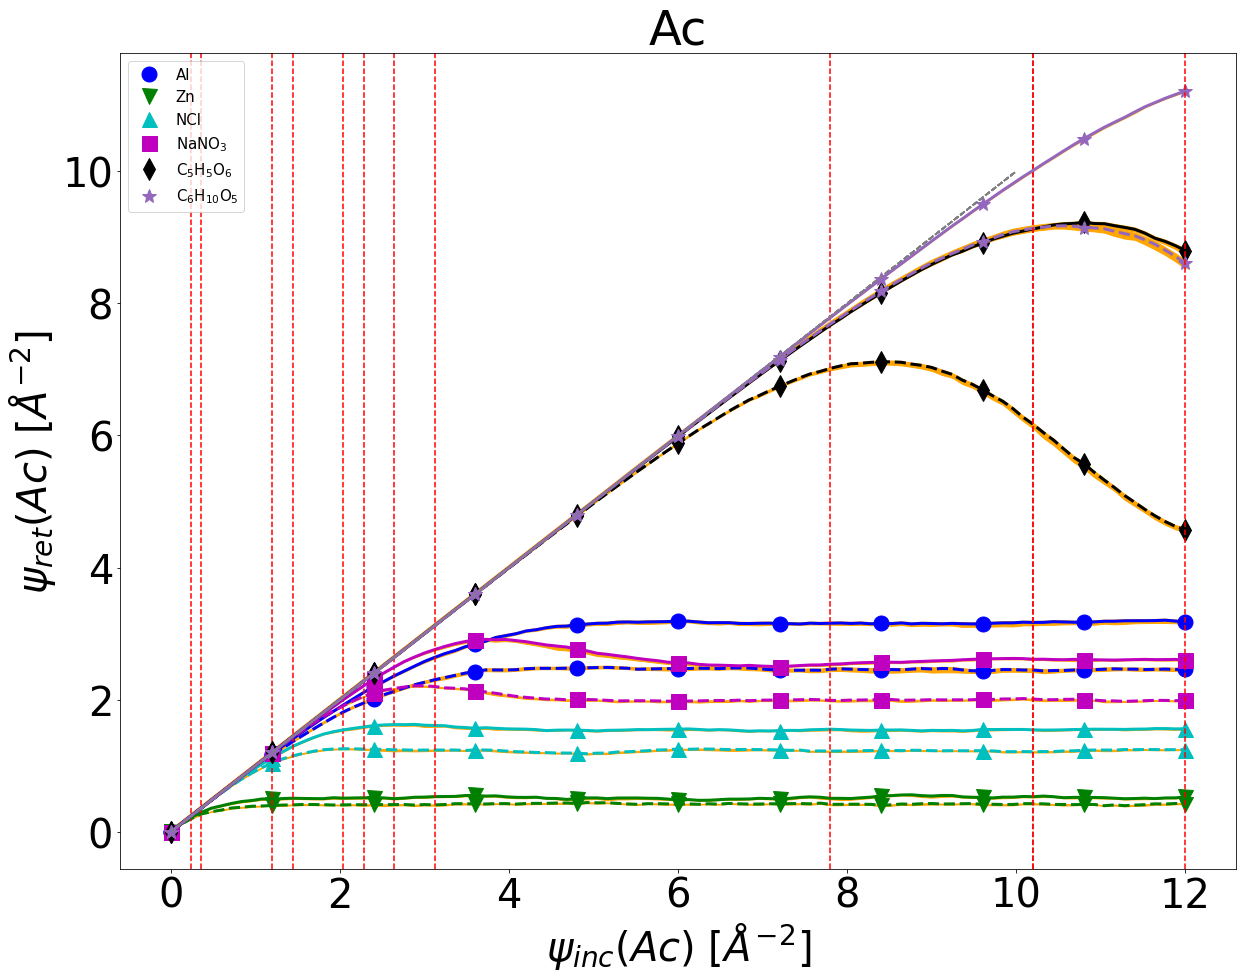

In [12]:
# define information about the isotope
isotopedict_Ac = {
    "energies" : [30,60],
    "isotope" : 'Ac',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Ac))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Acrow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Sc, Energy = 30keV
Start sputtering 4.32 $\AA^{-2}$, error = [0.13416408 0.13416408] $\AA^{-2}$
errorinfo
4.32+/-0.13
4.32+/-0.13
Start sputtering [0.00043488457896049225+/-1.3505992790583833e-05
 0.00043488457896049225+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Sc, Energy = 60keV
Start sputtering 10.08 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
10.08+/-0.06
10.08+/-0.13
Start sputtering [0.0010147306842411485+/-6.040063596673502e-06
 0.0010147306842411485+/-1.3505992790583752e-05] sigma_r C/mm
Foil = Zn, Isotope = Sc, Energy = 30keV
Start sputtering 0.6 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
0.60+/-0.06
0.60+/-0.13
Start sputtering [6.040063596673503e-05+/-6.040063596673502e-06
 6.040063596673503e-05+/-1.3505992790583824e-05] sigma_r C/mm
Foil = Zn, Isotope = Sc, Energy = 60keV
Start sputtering 1.44 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
1.44+/-0.06
1.44+/-0.13
Start sputter

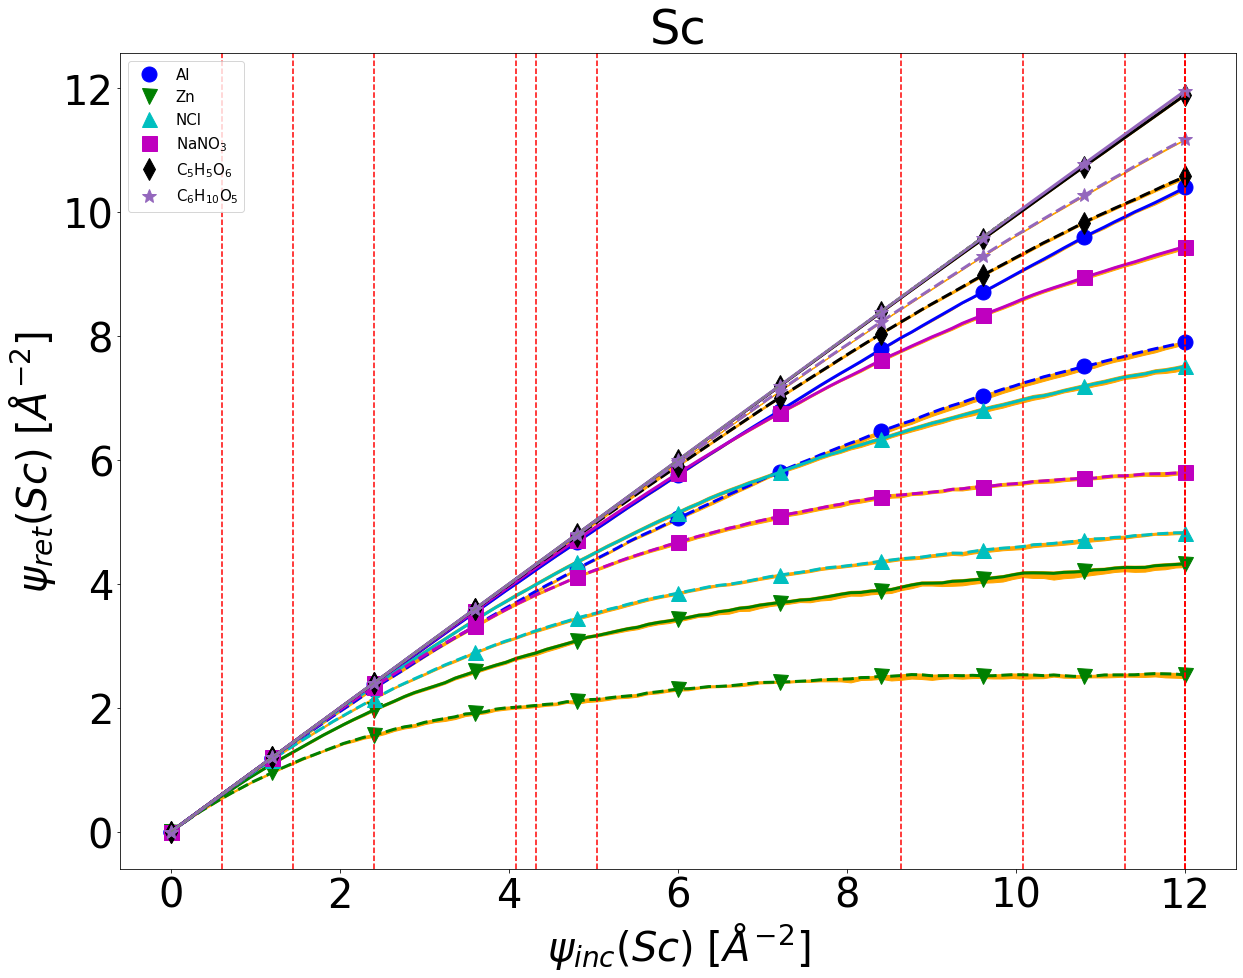

In [13]:
# define information about the isotope
isotopedict_Sc = {
    "energies" : [30,60],
    "isotope" : 'Sc',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Sc))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Scrow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Cu, Energy = 30keV
Start sputtering 3.0 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
3.00+/-0.06
3.00+/-0.13
Start sputtering [0.0003020031798336751+/-6.040063596673502e-06
 0.0003020031798336751+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Cu, Energy = 60keV
Start sputtering 5.52 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
5.52+/-0.06
5.52+/-0.13
Start sputtering [0.0005556858508939622+/-6.040063596673502e-06
 0.0005556858508939622+/-1.3505992790583752e-05] sigma_r C/mm
Foil = Zn, Isotope = Cu, Energy = 30keV
Start sputtering 0.36 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.36+/-0.06
0.36+/-0.06
Start sputtering [3.6240381580041014e-05+/-6.040063596673502e-06
 3.6240381580041014e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Cu, Energy = 60keV
Start sputtering 0.84 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.84+/-0.06
0.84+/-0.06
Start sputtering [8.456089035342902e-05+/-

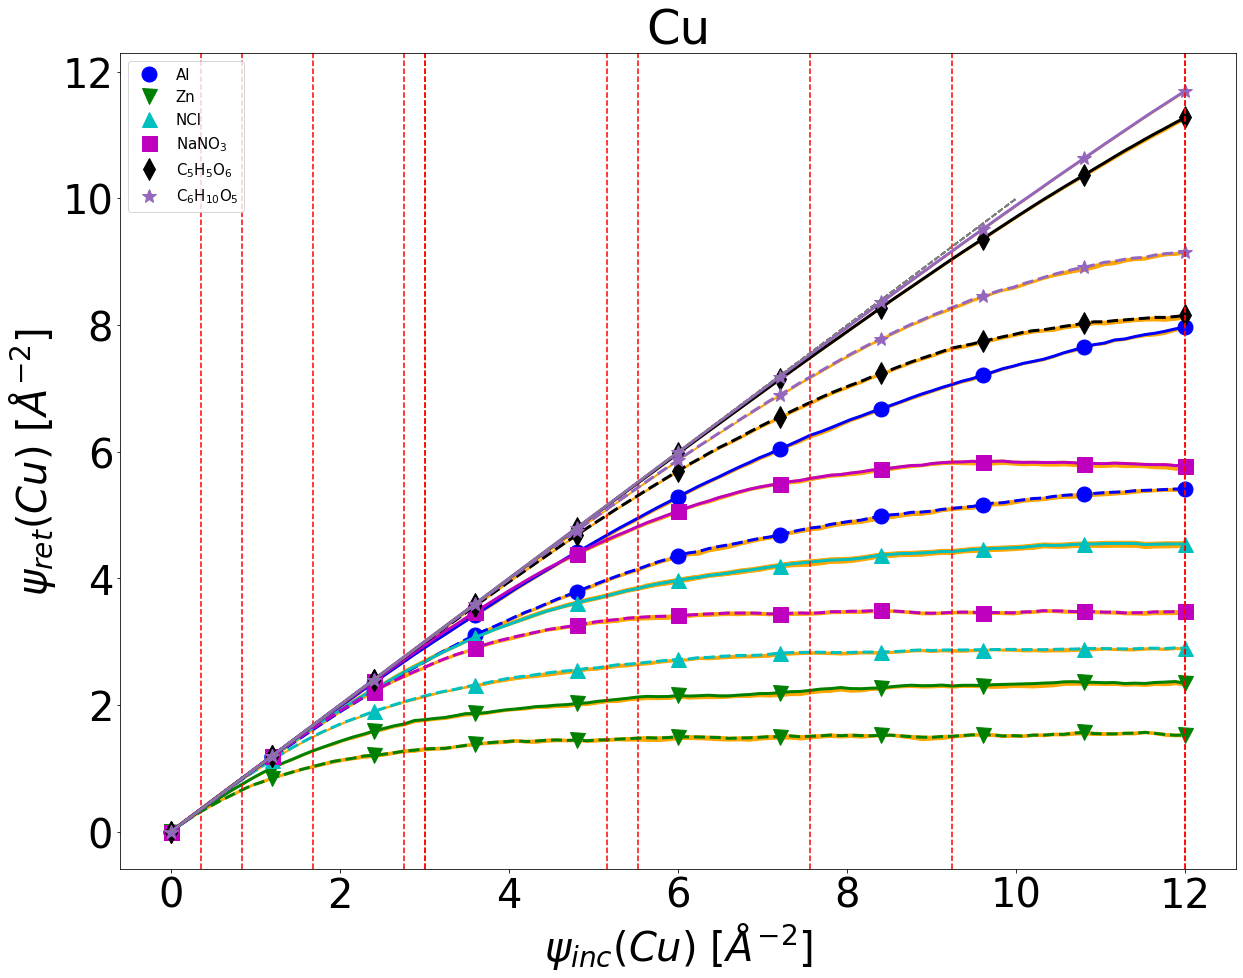

In [14]:
# define information about the isotope
isotopedict_Cu = {
    "energies" : [30,60],
    "isotope" : 'Cu',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Cu))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Curow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Sm, Energy = 30keV
Start sputtering 2.04 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
2.04+/-0.06
2.04+/-0.13
Start sputtering [0.0002053621622868991+/-6.040063596673502e-06
 0.0002053621622868991+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Sm, Energy = 60keV
Start sputtering 2.88 $\AA^{-2}$, error = [0.13416408 0.13416408] $\AA^{-2}$
errorinfo
2.88+/-0.13
2.88+/-0.13
Start sputtering [0.0002899230526403281+/-1.3505992790583833e-05
 0.0002899230526403281+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Zn, Isotope = Sm, Energy = 30keV
Start sputtering 0.24 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.24+/-0.06
0.24+/-0.06
Start sputtering [2.4160254386694007e-05+/-6.040063596673502e-06
 2.4160254386694007e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Sm, Energy = 60keV
Start sputtering 0.48 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.48+/-0.06
0.48+/-0.06
Start sputtering [4.8320508773388014e-05

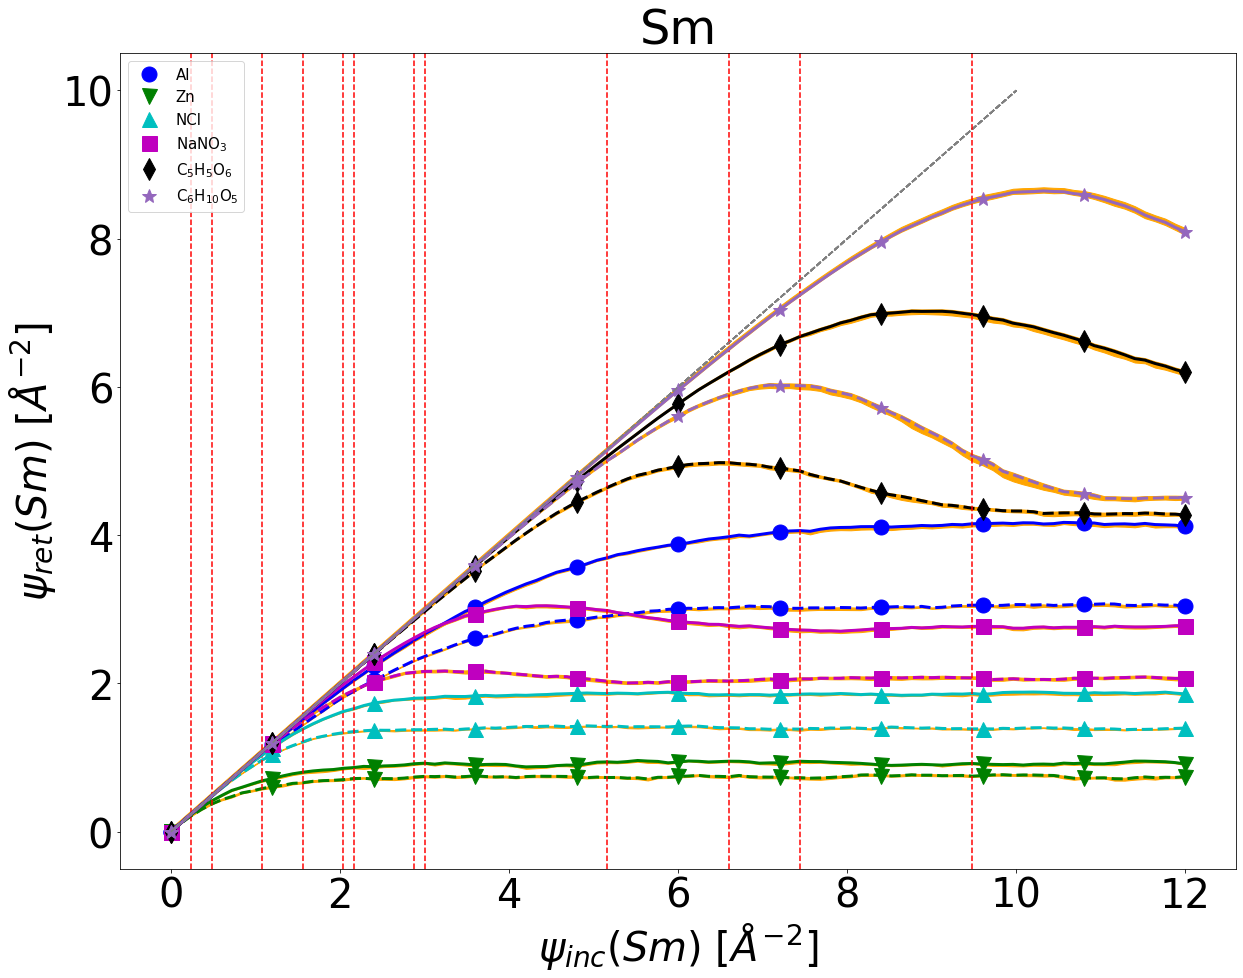

In [15]:
# define information about the isotope
isotopedict_Sm = {
    "energies" : [30,60],
    "isotope" : 'Sm',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Sm))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Smrow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Tb, Energy = 30keV
Start sputtering 2.16 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
2.16+/-0.06
2.16+/-0.06
Start sputtering [0.00021744228948024613+/-6.040063596673502e-06
 0.00021744228948024613+/-6.040063596673502e-06] sigma_r C/mm
Foil = Al, Isotope = Tb, Energy = 60keV
Start sputtering 3.12 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
3.12+/-0.13
3.12+/-0.06
Start sputtering [0.0003140833070270221+/-1.3505992790583833e-05
 0.0003140833070270221+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tb, Energy = 30keV
Start sputtering 0.36 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.36+/-0.06
0.36+/-0.06
Start sputtering [3.6240381580041014e-05+/-6.040063596673502e-06
 3.6240381580041014e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tb, Energy = 60keV
Start sputtering 0.48 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.48+/-0.06
0.48+/-0.06
Start sputtering [4.8320508773388014e-05+/-6.0400635

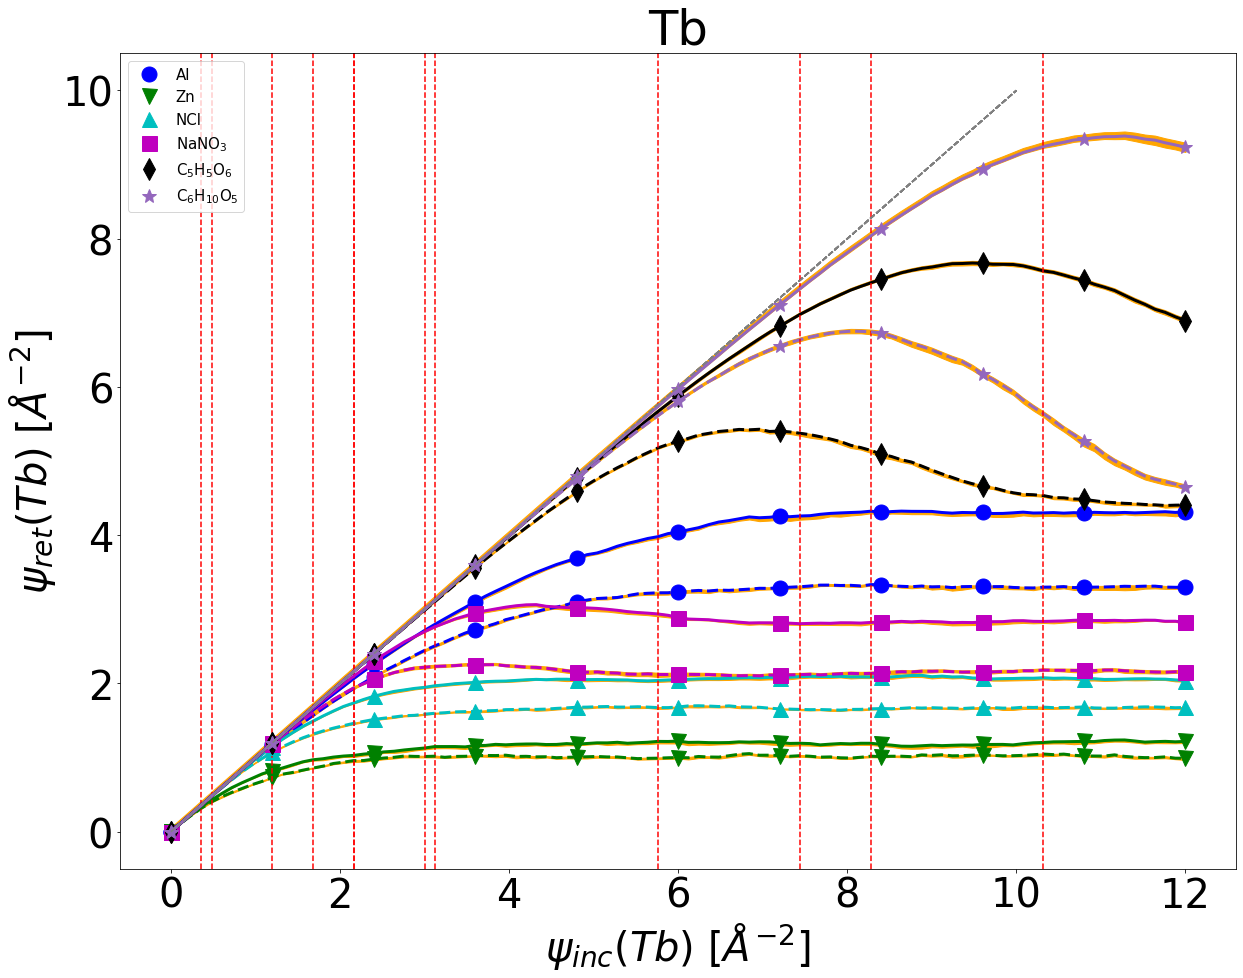

In [16]:
# define information about the isotope
isotopedict_Tb = {
    "energies" : [30,60],
    "isotope" : 'Tb',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Tb))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Tbrow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Tm, Energy = 30keV
Start sputtering 2.04 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
2.04+/-0.13
2.04+/-0.06
Start sputtering [0.0002053621622868991+/-1.3505992790583833e-05
 0.0002053621622868991+/-6.040063596673502e-06] sigma_r C/mm
Foil = Al, Isotope = Tm, Energy = 60keV
Start sputtering 2.88 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
2.88+/-0.13
2.88+/-0.06
Start sputtering [0.0002899230526403281+/-1.3505992790583833e-05
 0.0002899230526403281+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tm, Energy = 30keV
Start sputtering 0.24 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
0.24+/-0.13
0.24+/-0.06
Start sputtering [2.4160254386694007e-05+/-1.3505992790583824e-05
 2.4160254386694007e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tm, Energy = 60keV
Start sputtering 0.48 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
0.48+/-0.06
0.48+/-0.13
Start sputtering

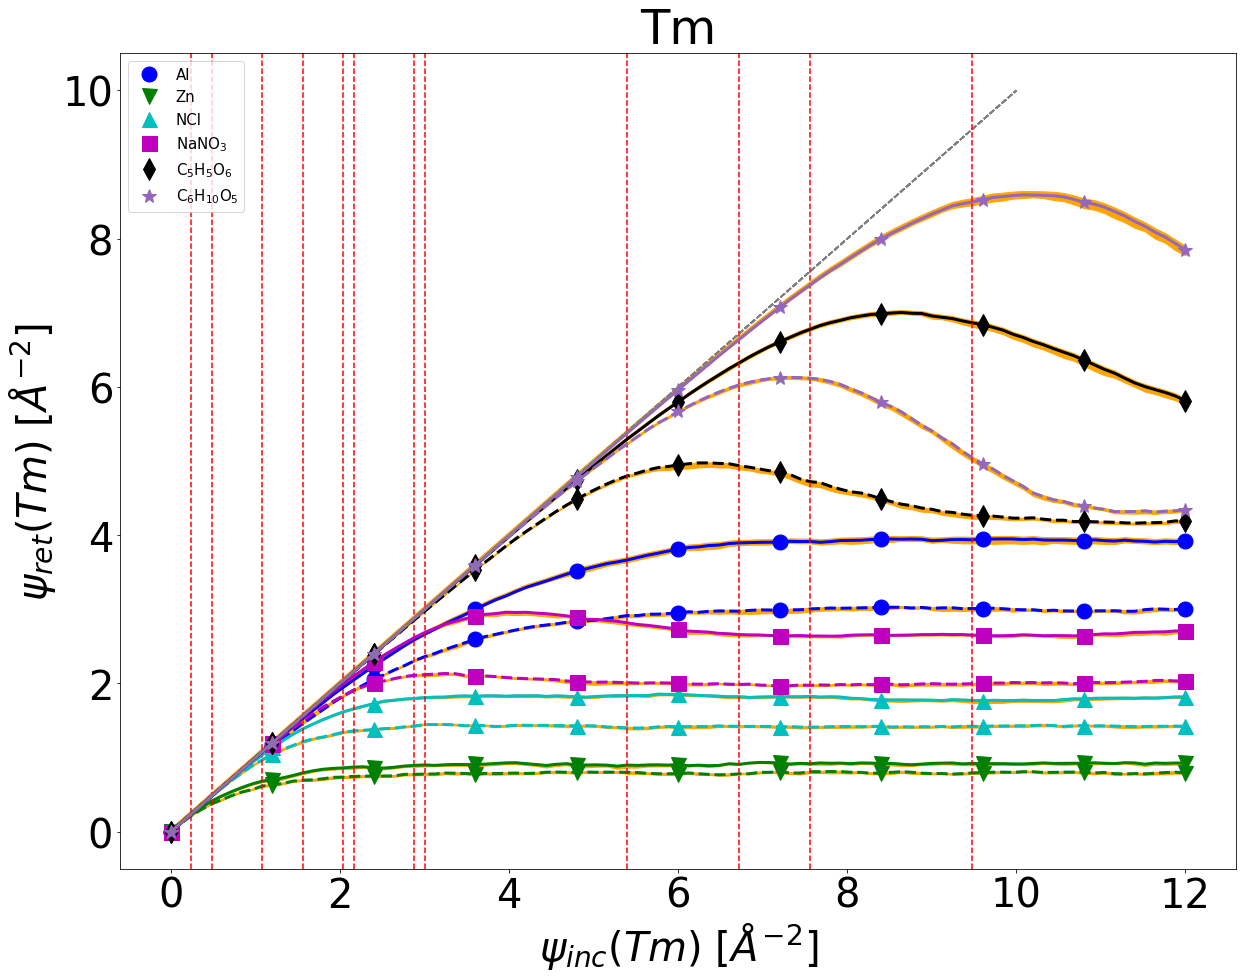

In [17]:
# define information about the isotope
isotopedict_Tm = {
    "energies" : [30,60],
    "isotope" : 'Tm',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_info
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Tm))
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Tmrow.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Tm, Energy = 30keV
Start sputtering 2.04 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
2.04+/-0.13
2.04+/-0.06
Start sputtering [0.0002053621622868991+/-1.3505992790583833e-05
 0.0002053621622868991+/-6.040063596673502e-06] sigma_r C/mm
Foil = Al, Isotope = Tm, Energy = 60keV
Start sputtering 2.88 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
2.88+/-0.13
2.88+/-0.06
Start sputtering [0.0002899230526403281+/-1.3505992790583833e-05
 0.0002899230526403281+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tm, Energy = 30keV
Start sputtering 0.24 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
0.24+/-0.13
0.24+/-0.06
Start sputtering [2.4160254386694007e-05+/-1.3505992790583824e-05
 2.4160254386694007e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Tm, Energy = 60keV
Start sputtering 0.48 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
0.48+/-0.06
0.48+/-0.13
Start sputtering

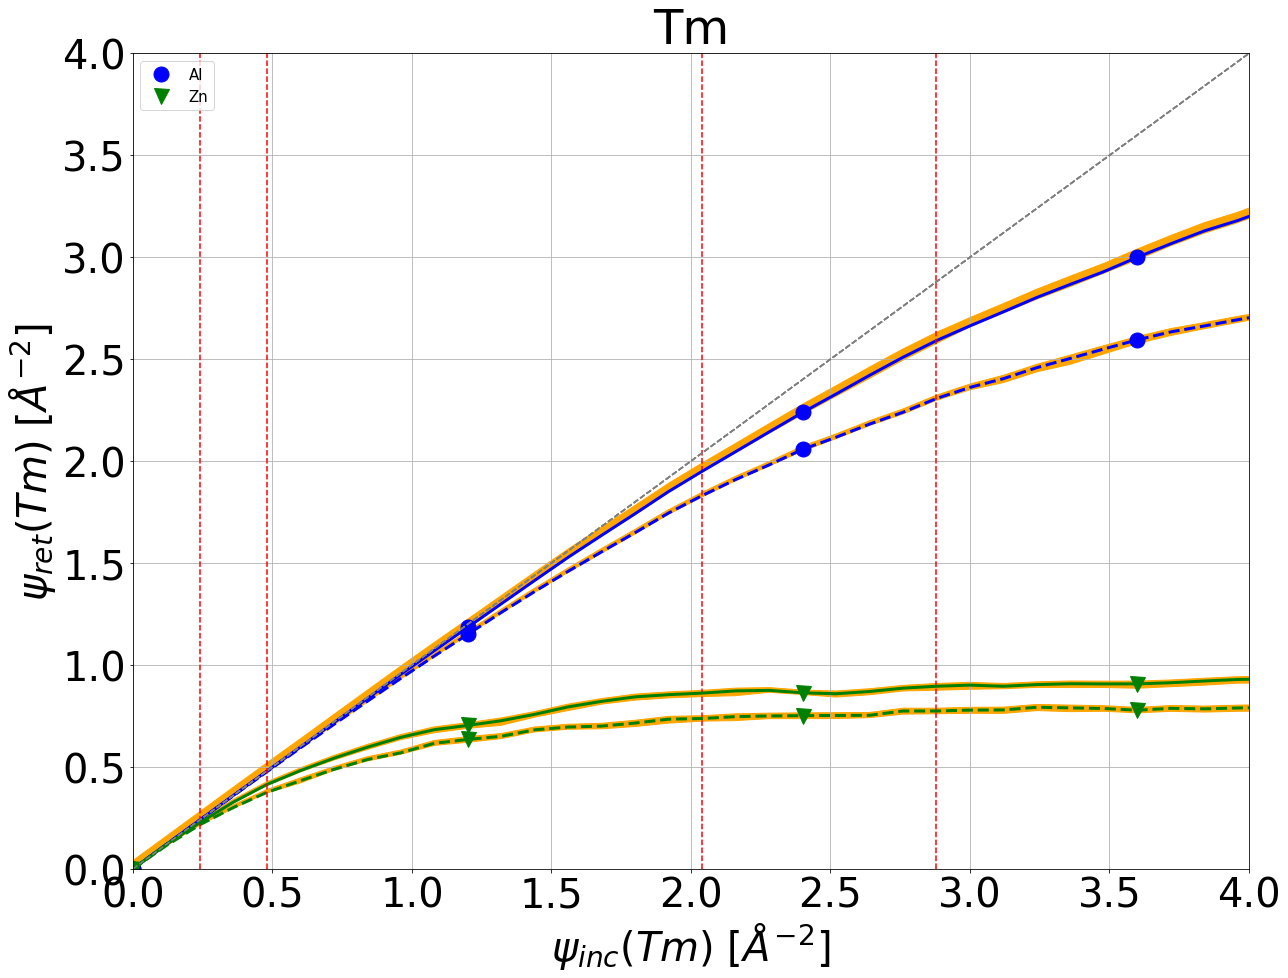

In [13]:
foil_dict_infoAlZn = {
    "foilmats" : ['Al','Zn'],
    "foilnames": ['Al','Zn'],
    "num_extends" : [0,0],
    "fractionss": [['x'],['x']],
    "colors" : ['b','g'],
    "symbols" : ['o','v'],
    "labelnames" : ['Al','Zn'],                
}
# define information about the isotope
isotopedict_Tm = {
    "energies" : [30,60],
    "isotope" : 'Tm',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_infoAlZn
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Tm))
plt.ylim(0,4)
plt.xlim(0,4)
plt.grid()
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/TmrowZnAl.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Er, Energy = 30keV
Start sputtering 2.16 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
2.16+/-0.06
2.16+/-0.13
Start sputtering [0.00021744228948024613+/-6.040063596673502e-06
 0.00021744228948024613+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Er, Energy = 60keV
Start sputtering 3.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
3.00+/-0.06
3.00+/-0.06
Start sputtering [0.0003020031798336751+/-6.040063596673502e-06
 0.0003020031798336751+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Er, Energy = 30keV
Start sputtering 0.24 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
0.24+/-0.13
0.24+/-0.06
Start sputtering [2.4160254386694007e-05+/-1.3505992790583824e-05
 2.4160254386694007e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Er, Energy = 60keV
Start sputtering 0.48 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.48+/-0.06
0.48+/-0.06
Start sputtering [4.8320508773388014e-05

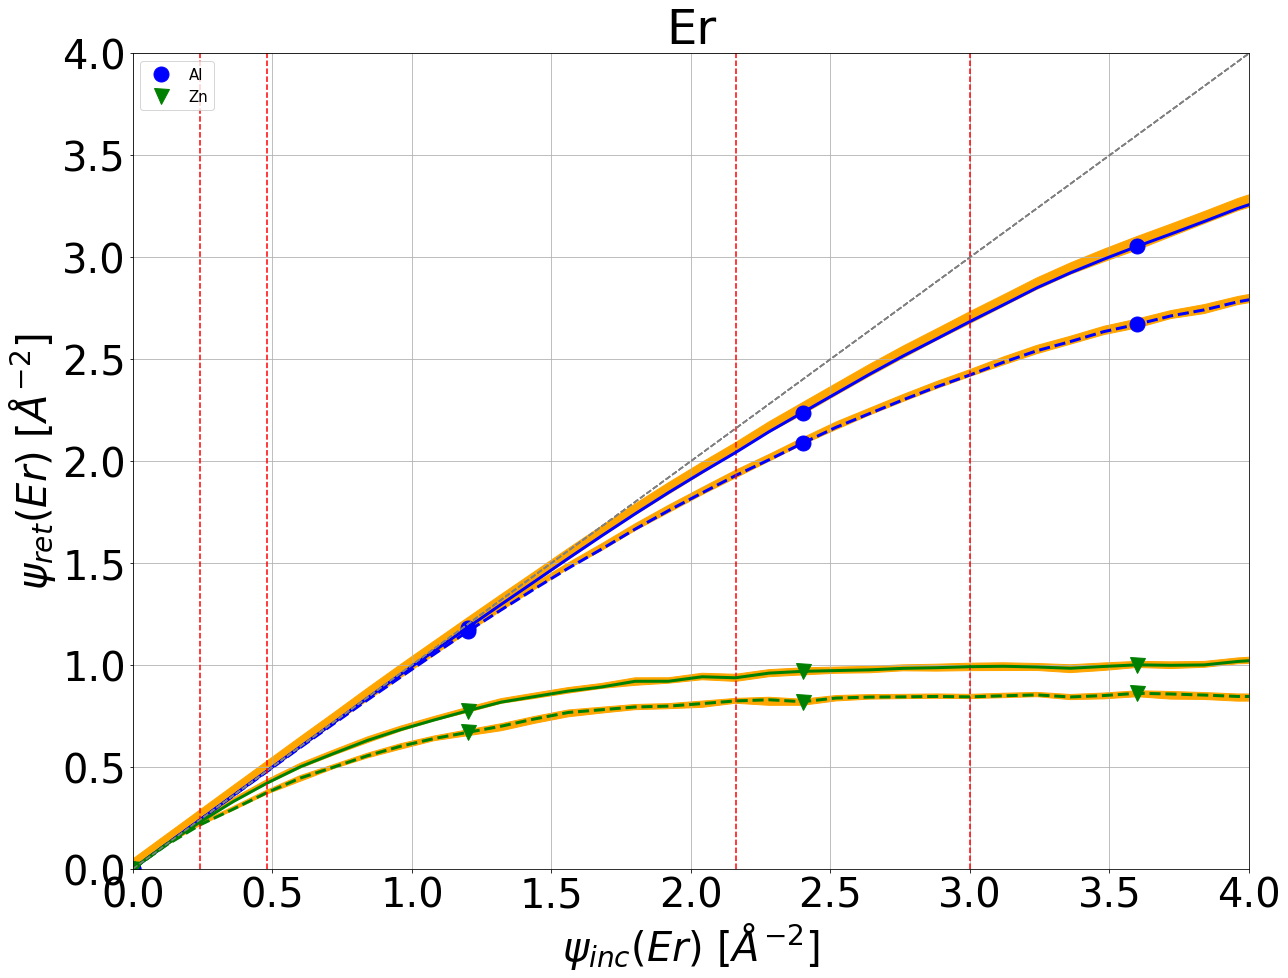

In [14]:
foil_dict_infoAlZn = {
    "foilmats" : ['Al','Zn'],
    "foilnames": ['Al','Zn'],
    "num_extends" : [0,0],
    "fractionss": [['x'],['x']],
    "colors" : ['b','g'],
    "symbols" : ['o','v'],
    "labelnames" : ['Al','Zn'],                
}
# define information about the isotope
isotopedict_Er = {
    "energies" : [30,60],
    "isotope" : 'Er',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "foil_info": foil_dict_infoAlZn
}

# retrieve back the information for a specific isotope
print(get_info_isotope(isotopedict_Er))
plt.ylim(0,4)
plt.xlim(0,4)
plt.grid()
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/ErrowZnAl.pdf')

# function to deterimine for one foil all (i.e. for all isotope) retained curves

In [18]:
def get_info_foil(foildict):
    energies = foildict['energies']
    foilmat = foildict['foilmat']
    folderpath = foildict['folderpath']
    foilname = foildict['foilname']
    isodict = foildict['isotopedict']
    num_extend = foildict['num_extend']
    
    if num_extend == 0:
        fractions = [0]
    else:
        fractions = foildict['fractions']
    
    plt.rcParams.update({'font.size': 40})
    for ii in range(len(isodict['isos'])):
        inputDict = {
            "foilmat" : foilmat,
            "foilname" :  foilname,
            "folderpath" : folderpath,
            "energies": energies,
            "num_extend":  num_extend,
            "color" :  (isodict["colors"])[ii],
            "symbol" :  (isodict["symbols"])[ii],
            "isotope" : (isodict["isos"])[ii],
            "fractions":  fractions,
            "labelname" :  (isodict["isos"])[ii]        
        }
        get_info(inputDict)
    plt.ylabel('$\psi_{ret}$ [$\AA^{-2}$]')
    plt.xlabel('$\psi_{inc}$ [$\AA^{-2}$]')
    plt.title('Foil = ' + foilname)

In [19]:
# define isotope information (all isotopes that are put in 1 graph)
iso_dict_info = {
    "isos" : ['Sc','Cu','Sm','Tb','Tm','Ac'],
    "colors" : ['b','g','c','m','k','tab:purple'],
    "symbols" : ['o','v','^','s','d','*'],
    "labelnames" : ['Sc','Cu','Sm','Tb','Tm','Ac']                
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Al, Isotope = Sc, Energy = 30keV
Start sputtering 4.32 $\AA^{-2}$, error = [0.13416408 0.13416408] $\AA^{-2}$
errorinfo
4.32+/-0.13
4.32+/-0.13
Start sputtering [0.00043488457896049225+/-1.3505992790583833e-05
 0.00043488457896049225+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Sc, Energy = 60keV
Start sputtering 10.08 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
10.08+/-0.06
10.08+/-0.13
Start sputtering [0.0010147306842411485+/-6.040063596673502e-06
 0.0010147306842411485+/-1.3505992790583752e-05] sigma_r C/mm
Foil = Al, Isotope = Cu, Energy = 30keV
Start sputtering 3.0 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
3.00+/-0.06
3.00+/-0.13
Start sputtering [0.0003020031798336751+/-6.040063596673502e-06
 0.0003020031798336751+/-1.3505992790583833e-05] sigma_r C/mm
Foil = Al, Isotope = Cu, Energy = 60keV
Start sputtering 5.52 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
5.52+/-0.06
5.52+/-0.13
Start sputter

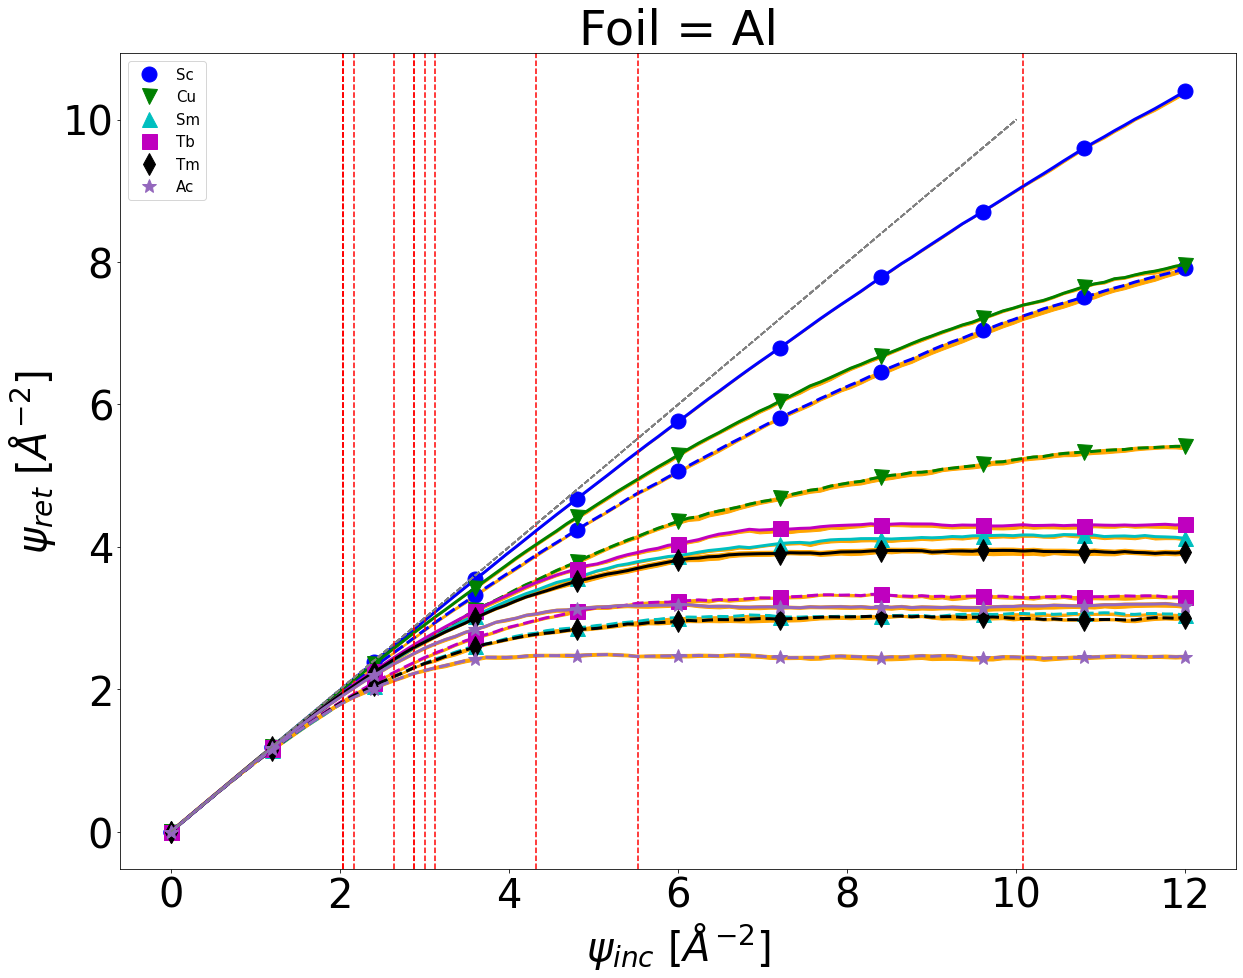

In [22]:
# define information about the foil
foildict_Al = {
    "energies" : [30,60],
    "foilmat" : 'Al',
    "foilname" : 'Al',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 0,
    "isotopedict": iso_dict_info
}

# retrieve back the information for a specific foil
get_info_foil(foildict_Al)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Alcolumn.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = Zn, Isotope = Sc, Energy = 30keV
Start sputtering 0.6 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
0.60+/-0.06
0.60+/-0.13
Start sputtering [6.040063596673503e-05+/-6.040063596673502e-06
 6.040063596673503e-05+/-1.3505992790583824e-05] sigma_r C/mm
Foil = Zn, Isotope = Sc, Energy = 60keV
Start sputtering 1.44 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
1.44+/-0.06
1.44+/-0.13
Start sputtering [0.00014496152632016406+/-6.040063596673502e-06
 0.00014496152632016406+/-1.3505992790583813e-05] sigma_r C/mm
Foil = Zn, Isotope = Cu, Energy = 30keV
Start sputtering 0.36 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.36+/-0.06
0.36+/-0.06
Start sputtering [3.6240381580041014e-05+/-6.040063596673502e-06
 3.6240381580041014e-05+/-6.040063596673502e-06] sigma_r C/mm
Foil = Zn, Isotope = Cu, Energy = 60keV
Start sputtering 0.84 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
0.84+/-0.06
0.84+/-0.06
Start sputtering [8.456089035342902e-05+

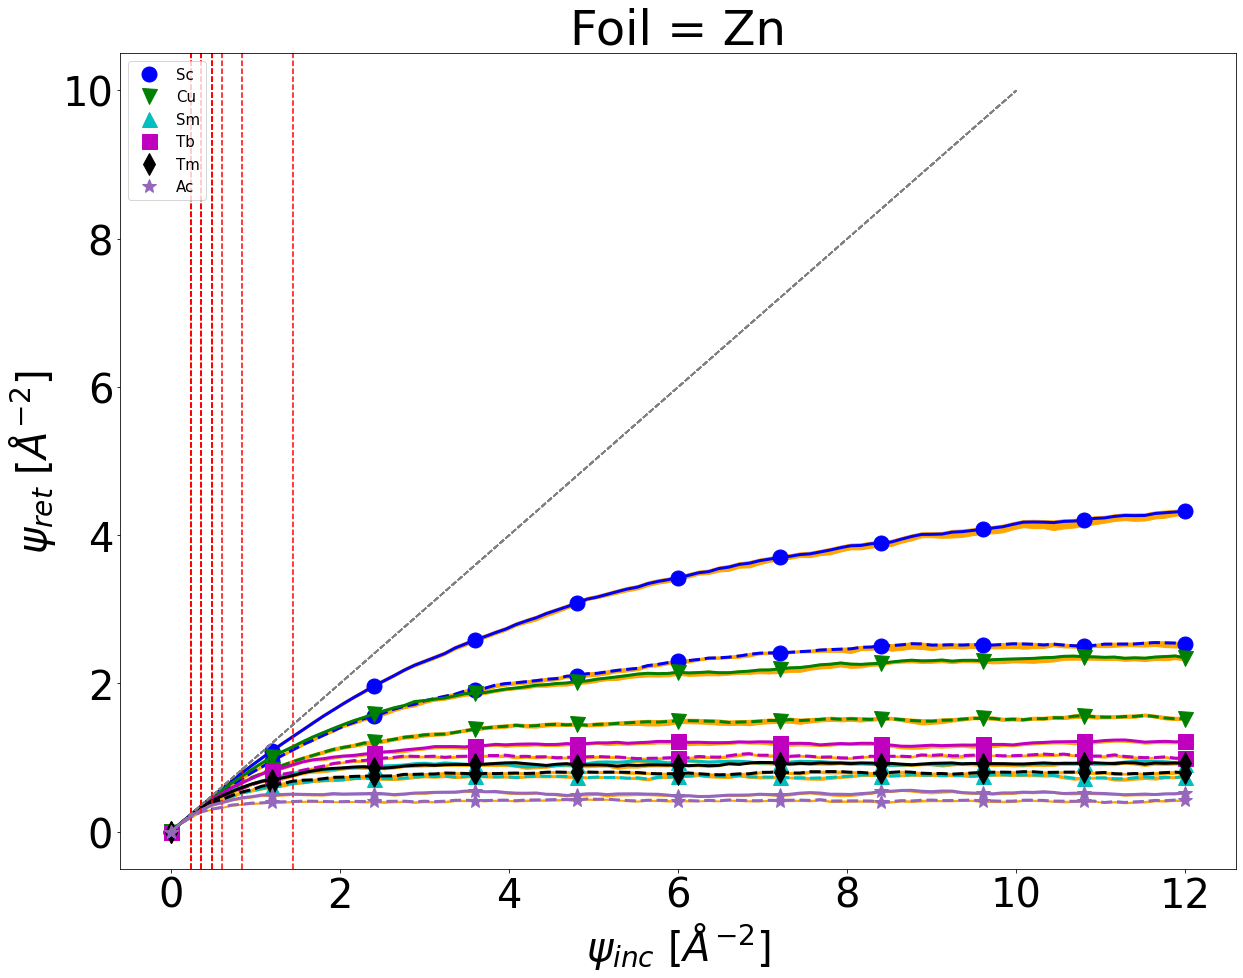

In [23]:
# define information about the foil
foildict_Zn = {
    "energies" : [30,60],
    "foilmat" : 'Zn',
    "foilname" : 'Zn',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 0,
    "isotopedict": iso_dict_info
}

# retrieve back the information for a specific foil
get_info_foil(foildict_Zn)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Zncolumn.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = NaCl, Isotope = Sc, Energy = 30keV
Start sputtering 2.4 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
2.40+/-0.06
2.40+/-0.06
Start sputtering [0.0002416025438669401+/-6.040063596673502e-06
 0.0002416025438669401+/-6.040063596673502e-06] sigma_r C/mm
Foil = NaCl, Isotope = Sc, Energy = 60keV
Start sputtering 5.04 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
5.04+/-0.06
5.04+/-0.13
Start sputtering [0.0005073653421205742+/-6.040063596673502e-06
 0.0005073653421205742+/-1.3505992790583833e-05] sigma_r C/mm
Foil = NaCl, Isotope = Cu, Energy = 30keV
Start sputtering 1.68 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
1.68+/-0.06
1.68+/-0.06
Start sputtering [0.00016912178070685804+/-6.040063596673502e-06
 0.00016912178070685804+/-6.040063596673502e-06] sigma_r C/mm
Foil = NaCl, Isotope = Cu, Energy = 60keV
Start sputtering 3.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
3.00+/-0.06
3.00+/-0.06
Start sputtering [0.0003020031798336751+/-6.0400

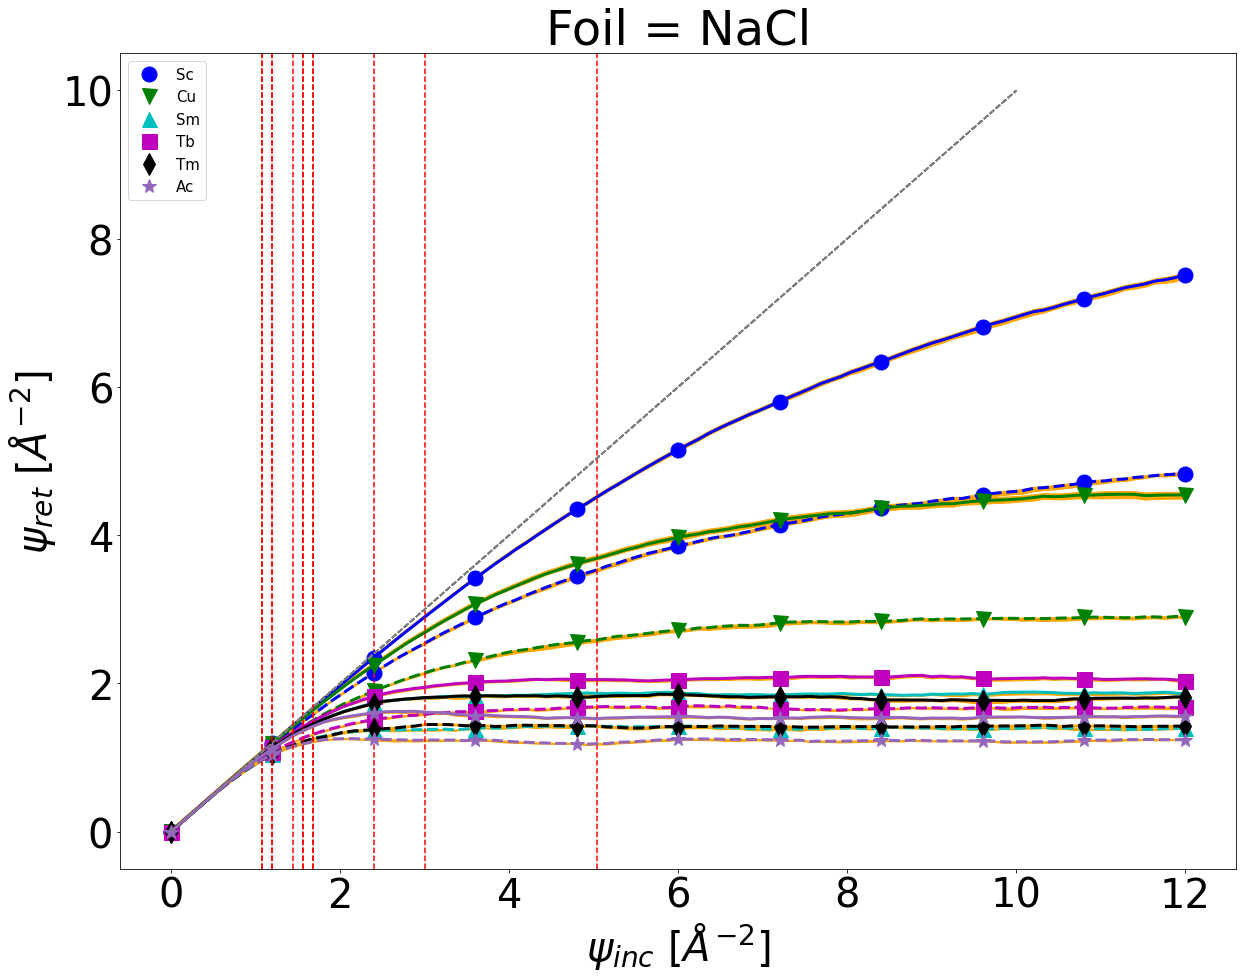

In [31]:
# example for a molecular foil

foildict_Nc = {
    "energies" : [30,60],
    "foilmat" : 'Nc',
    "foilname" : 'NaCl',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 2,
    'fractions': [0,1],
    "isotopedict": iso_dict_info
}
get_info_foil(foildict_Nc)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/Nccolumn.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = NaNO$_3$, Isotope = Sc, Energy = 30keV
Start sputtering 4.08 $\AA^{-2}$, error = [0.13416408 0.06      ] $\AA^{-2}$
errorinfo
4.08+/-0.13
4.08+/-0.06
Start sputtering [0.0004107243245737982+/-1.3505992790583833e-05
 0.0004107243245737982+/-6.040063596673502e-06] sigma_r C/mm
Foil = NaNO$_3$, Isotope = Sc, Energy = 60keV
Start sputtering 8.64 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
8.64+/-0.06
8.64+/-0.13
Start sputtering [0.0008697691579209845+/-6.040063596673502e-06
 0.0008697691579209845+/-1.3505992790583914e-05] sigma_r C/mm
Foil = NaNO$_3$, Isotope = Cu, Energy = 30keV
Start sputtering 2.76 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
2.76+/-0.06
2.76+/-0.13
Start sputtering [0.0002778429254469811+/-6.040063596673502e-06
 0.0002778429254469811+/-1.3505992790583794e-05] sigma_r C/mm
Foil = NaNO$_3$, Isotope = Cu, Energy = 60keV
Start sputtering 5.16 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
5.16+/-0.06
5.16+/

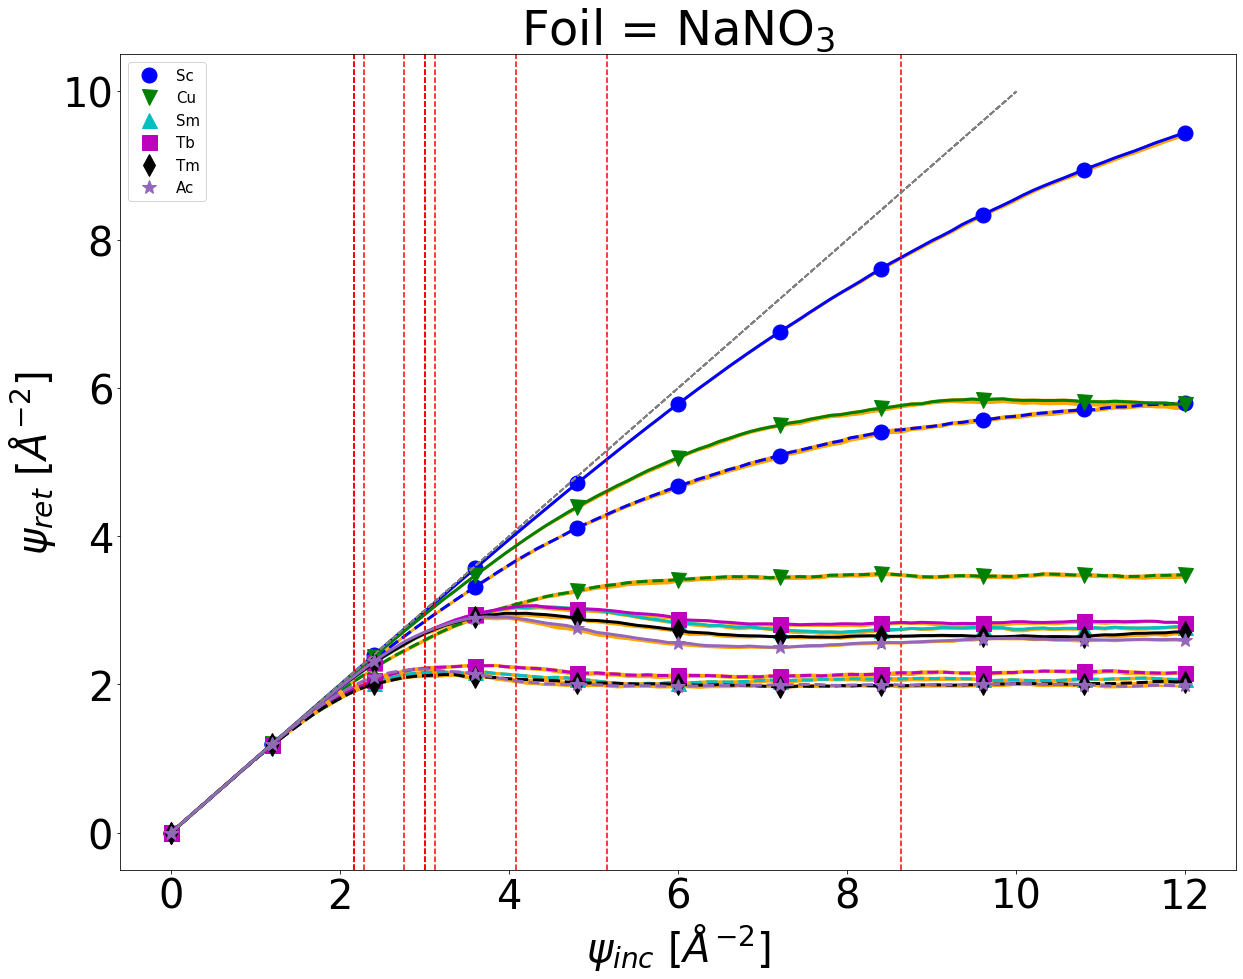

In [29]:
# example for a molecular foil

foildict_NaNO3 = {
    "energies" : [30,60],
    "foilmat" : 'NN',
    "foilname" : 'NaNO$_3$',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 3,
    'fractions': [0,0,1],
    "isotopedict": iso_dict_info
}
get_info_foil(foildict_NaNO3)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/NNcolumn.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Foil = C$_5$H$_5$O$_6$, Isotope = Sc, Energy = 30keV
Start sputtering 11.28 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
11.28+/-0.06
11.28+/-0.13
Start sputtering [0.0011355319561746184+/-6.040063596673502e-06
 0.0011355319561746184+/-1.3505992790583752e-05] sigma_r C/mm
12.0
12.0
Foil = C$_5$H$_5$O$_6$, Isotope = Sc, Energy = 60keV
Start sputtering 12.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
12.00+/-0.06
12.00+/-0.06
Start sputtering [0.0012080127193347004+/-6.040063596673502e-06
 0.0012080127193347004+/-6.040063596673502e-06] sigma_r C/mm
Foil = C$_5$H$_5$O$_6$, Isotope = Cu, Energy = 30keV
Start sputtering 7.56 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
7.56+/-0.06
7.56+/-0.13
Start sputtering [0.0007610480131808612+/-6.040063596673502e-06
 0.0007610480131808612+/-1.3505992790583752e-05] sigma_r C/mm
12.0
12.0
Foil = C$_5$H$_5$O$_6$, Isotope = Cu, Energy = 60keV
Start sputtering 12.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$


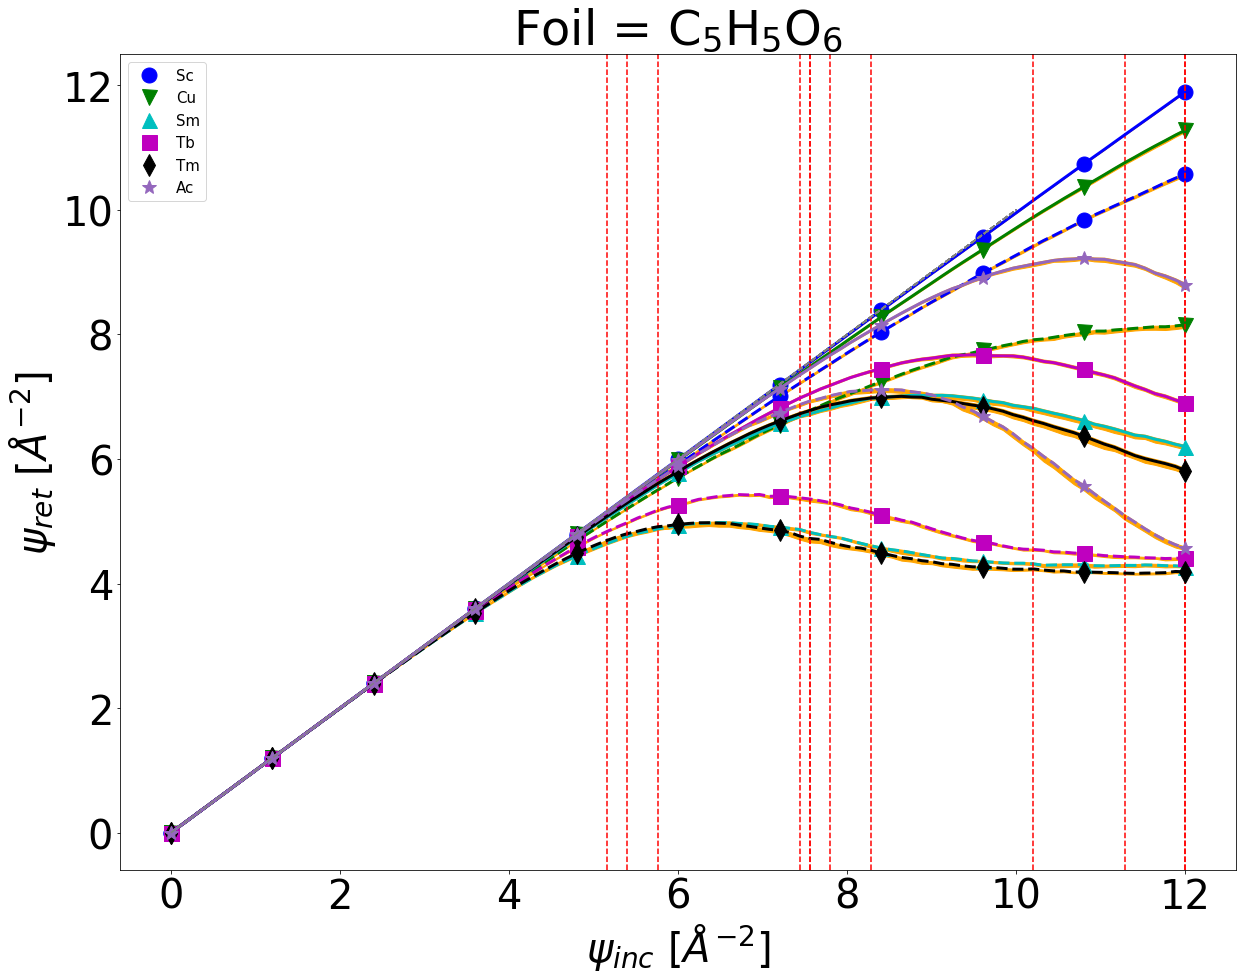

In [26]:
# example for a molecular foil

foildict_de = {
    "energies" : [30,60],
    "foilmat" : 'de',
    "foilname" : 'C$_5$H$_5$O$_6$',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 3,
    'fractions': [0,0,1],
    "isotopedict": iso_dict_info
}
get_info_foil(foildict_de)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/decolumn.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


12.0
12.0
Foil = C$_6$H$_{10}$O$_5$, Isotope = Sc, Energy = 30keV
Start sputtering 12.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
12.00+/-0.06
12.00+/-0.06
Start sputtering [0.0012080127193347004+/-6.040063596673502e-06
 0.0012080127193347004+/-6.040063596673502e-06] sigma_r C/mm
12.0
12.0
Foil = C$_6$H$_{10}$O$_5$, Isotope = Sc, Energy = 60keV
Start sputtering 12.0 $\AA^{-2}$, error = [0.06 0.06] $\AA^{-2}$
errorinfo
12.00+/-0.06
12.00+/-0.06
Start sputtering [0.0012080127193347004+/-6.040063596673502e-06
 0.0012080127193347004+/-6.040063596673502e-06] sigma_r C/mm
Foil = C$_6$H$_{10}$O$_5$, Isotope = Cu, Energy = 30keV
Start sputtering 9.24 $\AA^{-2}$, error = [0.06       0.13416408] $\AA^{-2}$
errorinfo
9.24+/-0.06
9.24+/-0.13
Start sputtering [0.0009301697938877195+/-6.040063596673502e-06
 0.0009301697938877195+/-1.3505992790583914e-05] sigma_r C/mm
12.0
12.0
Foil = C$_6$H$_{10}$O$_5$, Isotope = Cu, Energy = 60keV
Start sputtering 12.0 $\AA^{-2}$, error = [0.06 0.06] $\A

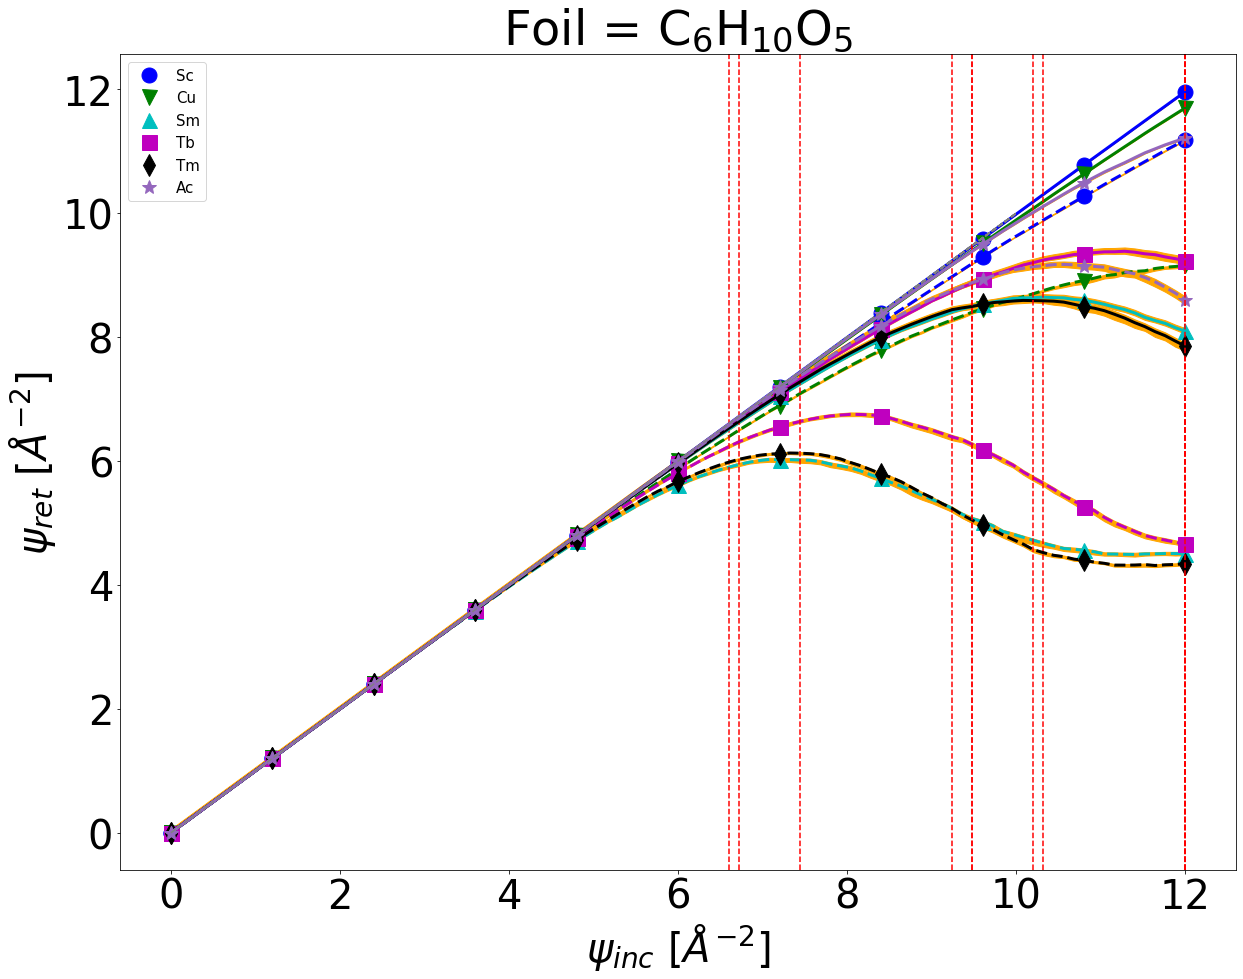

In [28]:
# example for a molecular foil

foildict_ce = {
    "energies" : [30,60],
    "foilmat" : 'ce',
    "foilname" : 'C$_6$H$_{10}$O$_5$',
    "folderpath" : "C:/Users/r0750853/linux/Othermedicalisotopes/Simulated_data/",
    "num_extend" : 3,
    'fractions': [0,0,1],
    "isotopedict": iso_dict_info
}
get_info_foil(foildict_ce)
plt.savefig('C:/Users/r0750853/Documents/Appendfigs/cecolumn.pdf')